# Quadratic Spoiling #

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.fft import fft

In [2]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 170e-3 #1000
T2 = 40e-3 #100
TR = 2.2e-3 
TE = TR/2
# tip angle alpha 10, 30, 90 degree
tip_angle = [10]
#phase cycling
Period = 12
#initial magnetisation 
M0 = np.asarray([[0],[0],[1]],dtype = float)






In [3]:
# FUNCTIONS
#RF pulse excitation matrix
def RF_pulse(alpha, phi):
    #The RF pulse tip the spin "alpha" degree from z axis
    #and a phase shift of "phi" degree clockwise from x axis
    
    #convert in to radians 
    a = math.radians(alpha)
    p = math.radians(phi)
    #each term of the matrix
    r11 = math.cos(a)*math.sin(p)**2 + math.cos(p)**2
    r12 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r13 = - math.sin(a)*math.sin(p)
    r21 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r22 = math.cos(a)*math.cos(p)**2 + math.sin(p)**2
    r23 = math.sin(a)*math.cos(p)
    r31 = math.sin(a)*math.sin(p)
    r32 = - math.sin(a)*math.cos(p)
    r33 = math.cos(a)
    R = np.asarray([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]], dtype = float)
    
    return R

#T1 recovery, T2 decay terms effect for time t
def Relaxation(t, T1, T2):
    e2 = np.exp(-t/T2)
    e1 = np.exp(-t/T1)
    E = np.asarray([[e2 , 0, 0],[0, e2, 0],[0, 0, e1]], dtype = float)
    
    return E

#Precession term effect on off-resonance (f_off Hz) spin at time t
def Precession(f_off, t):
    #free-precession angle beta
    b = f_off*t*2*math.pi
    #rad
    #b = math.radians(beta)
    P = np.asarray([[math.cos(b), math.sin(b), 0],[-math.sin(b), math.cos(b), 0],[0, 0, 1]], dtype = float)
    
    return P

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    n = n%N
    phi_quad = 360/N
    phase = phi_quad*n*n/2
 
    return phase


    

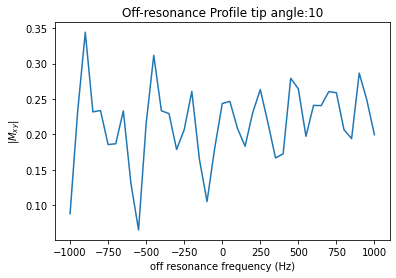

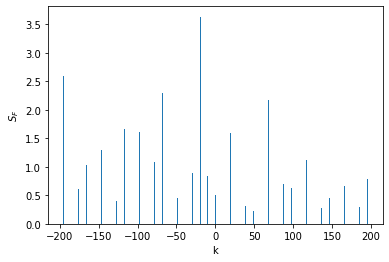

In [5]:


#----------------------------------------------------------------------------------------------
#draw for different tip angle, 10, 30, 90

for a in tip_angle:
    
    #store value
    off_resonance_f = np.asarray([], dtype = int)
   
    M_complex_steady = np.asarray([], dtype = float)

    #Find steady state value for different off-resonance 
    for f_off in range(-1000,1050,50):
        M_pre = M0 #initial pre pulse magnetisation 
        #templorary store value
        M_complex = np.asarray([], dtype = float)
        phase_shift = 0
        Period_num = 0

        #repeat 1000 times for each off-resonance frequency
        for k in range(1,10000):
            #Calculate phase shift for this TR
            phase_shift = QuadraticPhase(Period, Period_num)
            #Tip
            M_post = RF_pulse(a,phase_shift) @ M_pre
            
            #Consider T1 recovery, T2 decay and precession
            #@ time TE 
            P_TE = Precession(f_off,TE) #precession matrix at t = TE
            E_TE = Relaxation(TE, T1, T2) #Relaxation matrix at t = TE

            M_TE = P_TE @ E_TE @ M_post + (np.identity(3) - E_TE) @ M0 #magnetisation at TE
            #M_transverse = np.sqrt(M_TE[0]**2+M_TE[1]**2)

            #@ time TR 
            P_TR = Precession(f_off,TR) #precession matrix at t = TR
            E_TR = Relaxation(TR, T1, T2) #Relaxation matrix at t = TR
            M_TR = P_TR @ E_TR @ M_post + (np.identity(3) - E_TR) @ M0 #magnetisation at TR
            M_pre = M_TR
            
            M_complex = np.append(M_complex, complex(M_TE[0],M_TE[1]))
           
            Period_num = Period_num + 1
            
            
        #END
        #take the final steady signal
        M_complex_steady = np.append(M_complex_steady, M_complex[-1])
        off_resonance_f = np.append(off_resonance_f, f_off)
        
        
    #END
    S_F = np.fft.fft(M_complex_steady)
    S_F = np.absolute(S_F)
    S_F = np.fft.fftshift(S_F)
   
    F_state = np.fft.fftfreq(M_complex_steady.shape[-1], d = 1.0)
    F_state = np.fft.fftshift(F_state)*400
    #the maximum off-resonance frequency in the simulaiton 
  

    

    
    
    #plot M_xy at steady state against off-resonance frequency
    plt.figure(1)
    plt.plot(off_resonance_f, np.absolute(M_complex_steady))
    plt.xlabel("off resonance frequency (Hz)")
    plt.ylabel("$|M_{xy}|$")
    plt.title("Off-resonance Profile tip angle:" + str(a))
    #plt.savefig("FEMR1.jpg")
   
    plt.figure(2)
    plt.bar(F_state, S_F)
    plt.xlabel("k")
    plt.ylabel("$S_F$")
    #plt.title()
    #save figure
    
   

## 